In [1]:
import cv2
import numpy as np
import math
from PIL import Image
from IPython.display import display

In [35]:
def normalize_coordinate(x, y, width_equirect, height_equirect):
    x_prime = 2 * x / width_equirect - 1
    y_prime = 1 - 2 * y / height_equirect
    return (x_prime, y_prime)

In [36]:
def long_lat(x_prime, y_prime, lambda_0):
    longitude = math.pi * x_prime + lambda_0
    latitude = math.pi/2 * y_prime
    return (longitude, latitude)

In [37]:
def normalized_2D_fisheye_coord(latitude, longitude, aperture_in_rad, width, height, x, y):
    P_x = math.cos(latitude) * math.cos(longitude)
    P_y = math.cos(latitude) * math.sin(longitude)
    P_z = math.sin(latitude)
    
    theta = math.atan2(P_z, P_x)
    
    sqrt_for_r = math.sqrt(P_x**2 + P_z**2)
    if (P_y != 0):
        r = 2 * math.atan2(sqrt_for_r, P_y) / aperture_in_rad
    else:
        r = 0
    
    x_2 = (width - 1) * (theta / (2 * math.pi) + 0.5)
    y_2 = (height - 1) * (r / 2)
    
    return (x_2, y_2)

In [46]:
def project_image(input_image_path, output_image_path):
    fisheye_image = cv2.imread(input_image_path)
    height, width = fisheye_image.shape[:2]
    
    width_equirect = 2 * width
    height_equirect = height
    
    fov = 190
    aperture = math.radians(180)
    
    # Create a blank image for the unwrapped equirectangular projection
    unwrapped_image = np.zeros((height_equirect, width_equirect, 3), dtype=np.uint8)

    
    for x in range(width_equirect):
        for y in range(height_equirect):
            (x_prime, y_prime) = normalize_coordinate(x, y, width_equirect, height_equirect)
            (longitude, latitude) = long_lat(x_prime, y_prime, math.pi/2)
            (x_2, y_2) = normalized_2D_fisheye_coord(latitude, longitude, aperture, width_equirect, height_equirect, x, y)
            
            # Map the pixel value from fisheye image to the unwrapped image 
            if 0 <= x_2 < width and 0 <= y_2 < height:
                unwrapped_image[y, x] = fisheye_image[int(y_2), int(x_2)]
    
            
    
    
    # Save the unwrapped image
    cv2.imwrite(output_image_path, unwrapped_image)
    

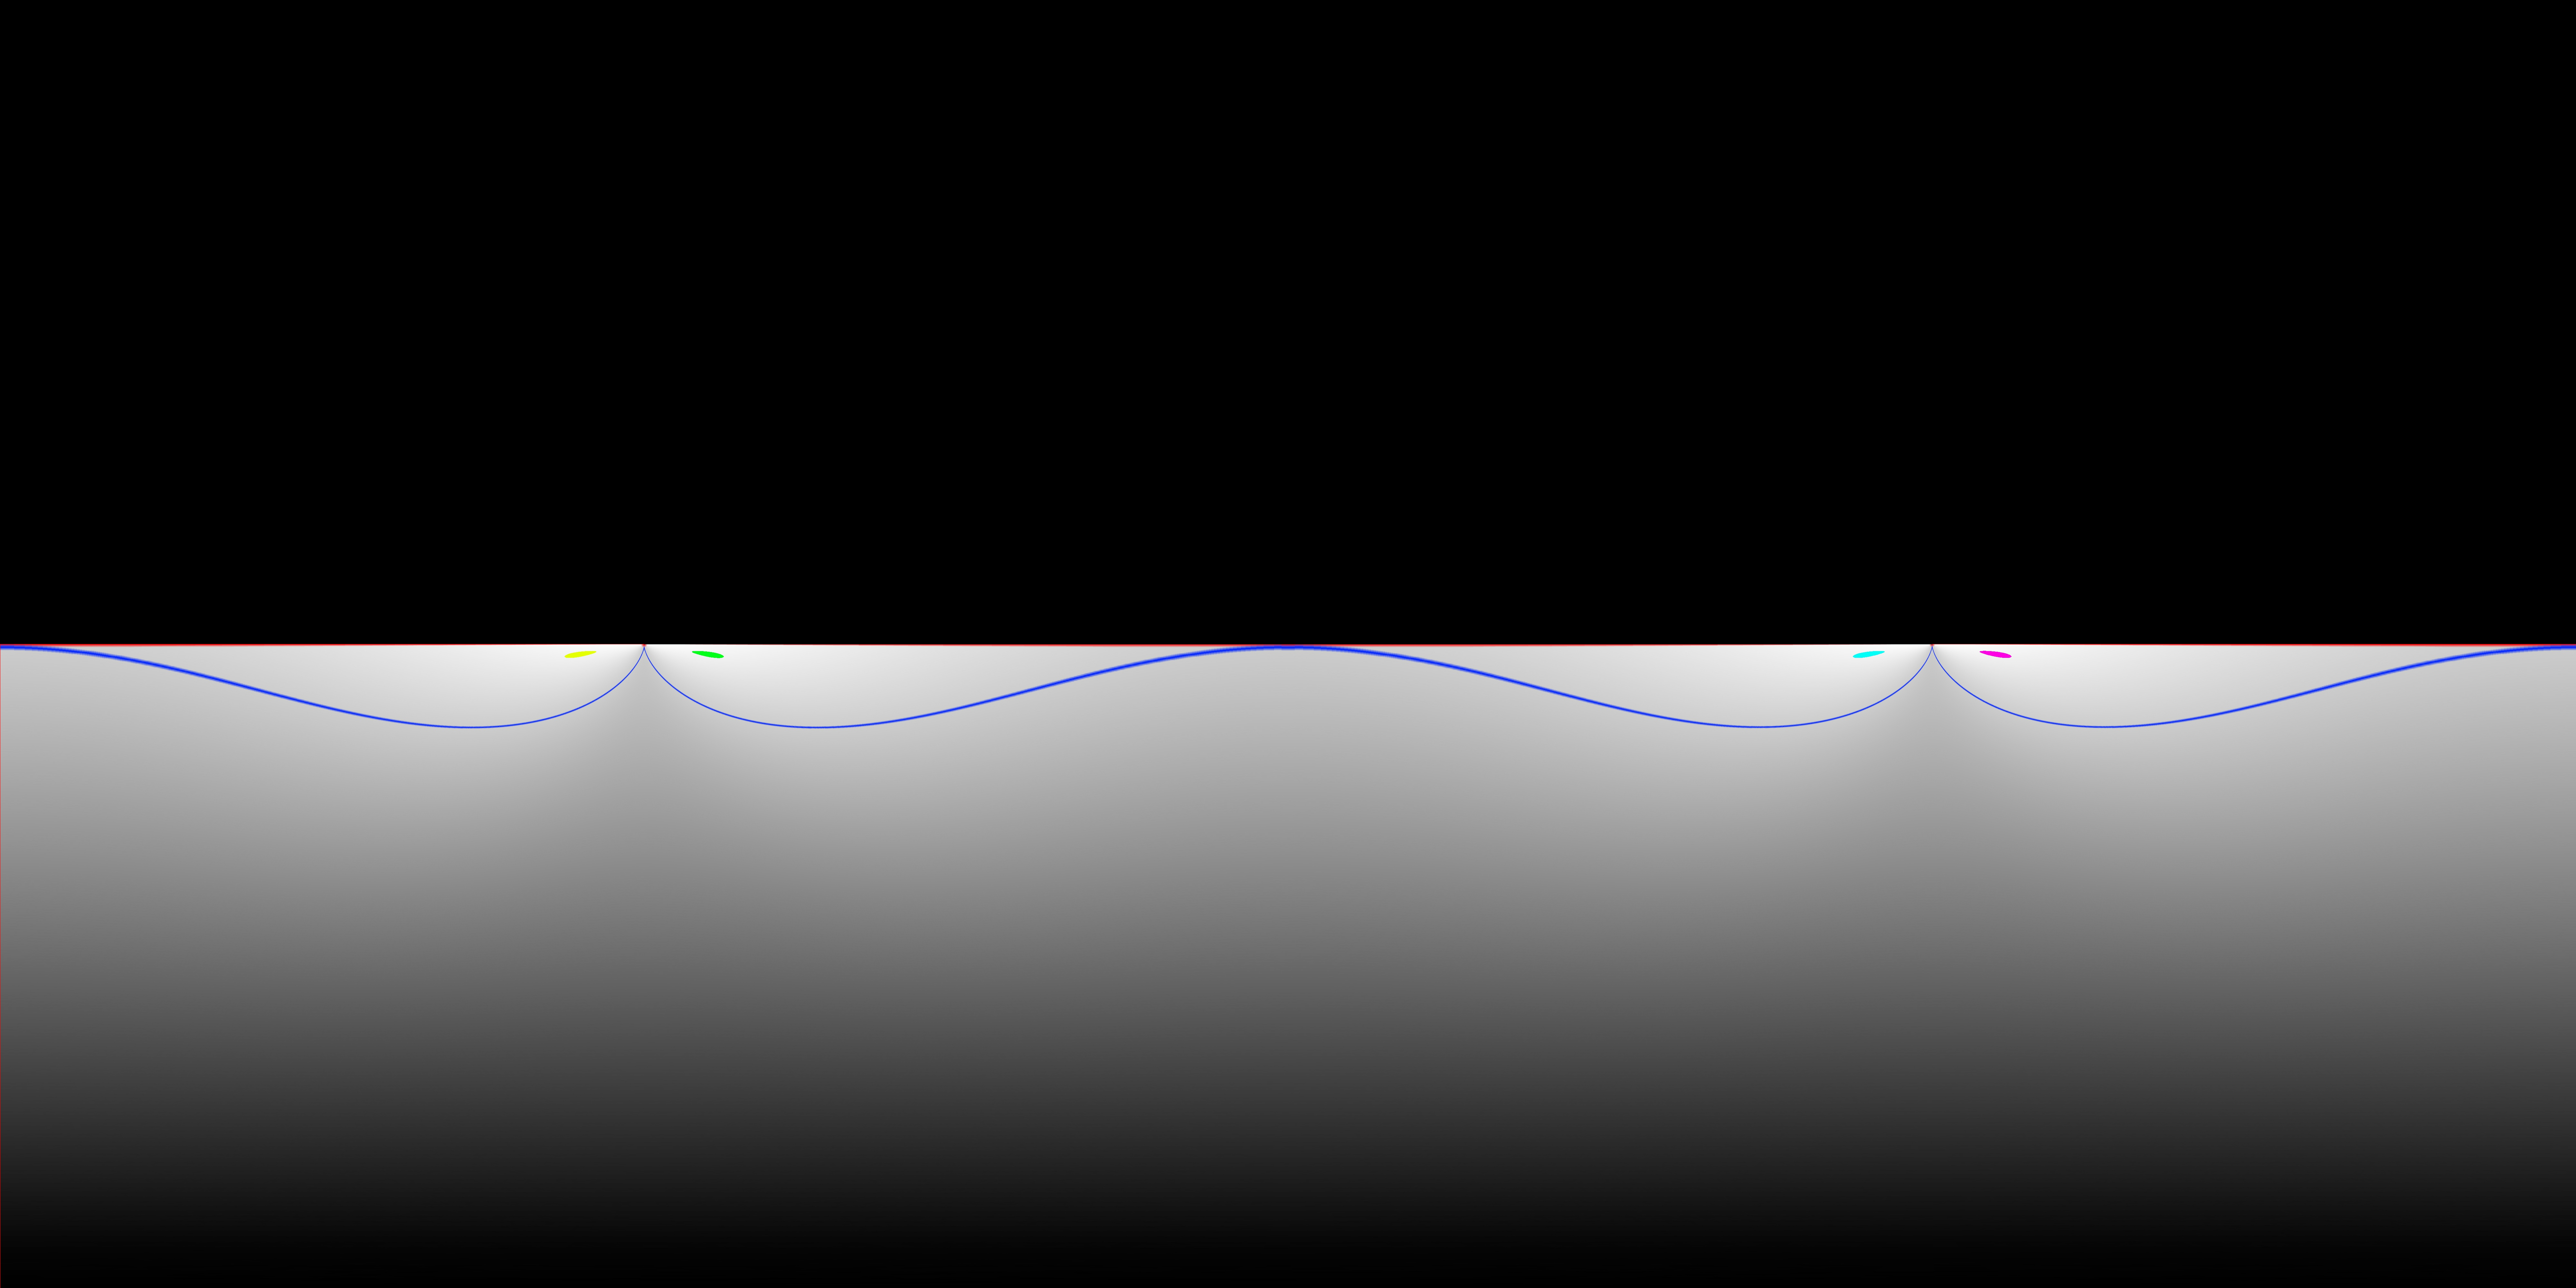

In [48]:
input_image_path = "Images/sample.jpg"
output_image_path = "Images_undistorted/test_undistort.jpg"

project_image(input_image_path, output_image_path)

img_test_undistort = Image.open(output_image_path)
display(img_test_undistort)